### The MLDA sampler
This notebook is a good starting point to understand the basic usage of the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) proposed in [1], as implemented within PyMC3.

It uses a simple linear regression model (and a toy coarse model counterpart) to show the basic workflow of using the method. The model is similar to the one used in https://docs.pymc.io/notebooks/GLM-linear.html.

The MLDA sampler is designed to deal with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost. Its main idea is that coarser chains' samples are used as proposals for the finer chains. This has been shown to improve the effective sample size of the finest chain and this allows us to reduce the number of expensive fine-chain likelihood evaluations. 

The PyMC3 implementation supports any number of levels, tuning parameterization for the bottom-level sampler, separate subsampling rates for each level, choice between blocked and compound sampling for the bottom-level sampler. More features like support for two types of bottom-level samplers (Metropolis, DEMetropolisZ), adaptive error correction and variance reduction are currently under development.

For more details about the MLDA sampler and the way it should be used and parameterised, the user can refer to the docstrings in the code and to the other example notebooks which deal with more complex problem settings and more advanced MLDA features.

[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

### Work flow

MLDA is used in a similar way as most step method in PyMC3. It has the special requirement that the user need to provide at least one coarse model to allow it to work.

The basic flow to use MLDA consists of four steps, which we demonstrate here using a simple linear regression model with a toy coarse model counterpart.


##### Step 1: Generate some data

Here, we generate a vector `x` of 50 points equally spaced between 0.0 and 1.0. Then we project those onto a straight line with intercept 1.0 and slope 2.0, adding some random noise, resulting in a vector `y`$. The goal is to infer the intercept and slope from `x` and `y`, i.e. a very simple linear regression problem.

In [31]:
import pymc3 as pm
import numpy as np
np.random.seed(915623497)

true_intercept = 1
true_slope = 2
size = 200
sigma = 1

x = np.linspace(0, 1, size)
y = true_intercept + true_slope * x + np.random.normal(0, sigma ** 2, size)

##### Step 2: Define the fine model

In this step we use the PyMC3 model definition language to define the priors and the likelihood. We choose non-informative Normal priors for both intercept and slope and a Normal likelihood, where we feed in `x` and `y`.

In [32]:
with pm.Model() as fine_model:
    # Define priors
    intercept = pm.Normal('intercept', 0, sigma=20)
    slope = pm.Normal('slope', 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x,
                        sigma=sigma, observed=y)

##### Step 3: Define a coarse model
    
Here, we define a toy coarse model where coarseness is introduced through a `bias` term in the likelihood mean.

In [33]:
with pm.Model() as coarse_model:
    # Define priors
    intercept = pm.Normal('intercept', 0, sigma=20)
    slope = pm.Normal('slope', 0, sigma=20)
    bias = 0.05

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + bias + slope * x,
                        sigma=sigma, observed=y)

##### Step 4: Draw MCMC samples from the posterior using MLDA 

We feed `coarse_model` to the MLDA instance and we also set the `subsampling rate` to 6. Note that `pm.MLDA` has many other tuning arguments which can be found in the documentation. Finally, we use the universal `pm.sample` method, passing the MLDA instance to it. This runs MLDA and returns a `trace`, containing all MCMC samples and various by-products. PyMC3 provides various functions to visualise the trace and print summary statistics (two of them are show here)

In [34]:
with fine_model:
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[6])
    trace = pm.sample(draws=3000, chains=4, tune=1000, step=step, random_seed=41567)

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [slope, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/gmingas/opt/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaa1c78b00>,
      dtype=object)

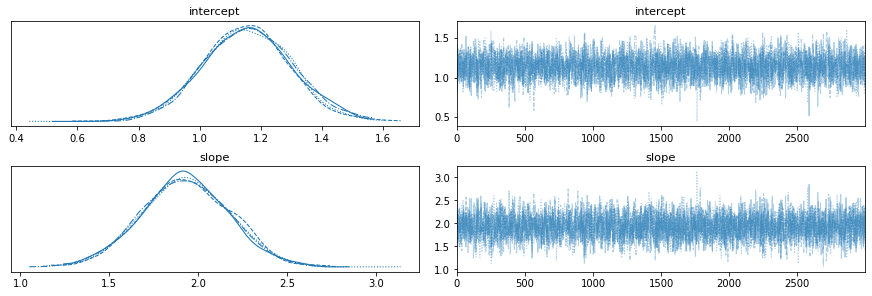

In [35]:
pm.plots.traceplot(trace)

In [36]:
pm.stats.summary(trace)

/Users/gmingas/opt/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.154,0.142,0.896,1.432,0.003,0.002,2985.0,2831.0,2971.0,2582.0,1.0
slope,1.930,0.243,1.484,2.391,0.004,0.003,3481.0,3481.0,3483.0,3558.0,1.0
